# Human Activity Recognition: 3 Different Approaches

This notebook is broken down into four main sections:

1. Data Summary & Analysis Goals
2. EDA
3. Modeling
4. Results
5. Conclusion
6. Next Steps

Each of these sections will be broken down into subsections and will have information that is needed to create a cohesive report.

###### Training on AWS

I chose to look at this data set from more than the "traditional" approach, which led to some time consuming and computationally expensive parts of the analysis. These were run on AWS, on a **c5d.4xlarge** instance (32 Gib RAM, 16 Cores) to be specific. The [setup file](setup.sh) can be sourced on the instance to set up the appropriate environment (Downloads Anaconda, the Imbalanced-Learn package, adds anaconda to PATH, and adds the src/ directory to the PYTHONPATH).

### Data Summary & Analysis Goals

#### Data Summary

15 participants wore an accelerometer mounted to their chest while performing seven different activities:

1. Working at Computer
2. Standing up, Walking and Going Up/Down Stairs
3. Standing
4. Walking
5. Going Up/Down Stairs
6. Walking and Talking w/ Someone
7. Talking while Standing

The accelerometer captured acceleration measurements in **three dimensions - X, Y and Z**. Each participant's measurement are in their own file, along with the activity they were performing at that time. Each subject has 6,000 - 16,000 observations, totaling 1,926,896 observations.

It is important to note that although the absolute quantity of observations this data set contains is quite high (roughly 2 million), there were only *15* people from whom measurements were taken (14 in the training data set).

In the grand scheme of things, this is relatively small sample. Since this analysis works with accelerometer data, one should keep in mind that a person's physical body size plays a role in how their body moves. For example, if all 14 applicants were smaller people, the model might not generalize well to larger individuals. Since there isn't any information on this in the problem description, there is no way to tell whether this variation has been captured by who ever designed this experiment. One would have to keep this in mind if the experiment were to be redesigned.

The data I will be working with (shown below) has 6 columns:

1. seq - The sequence number (per participant) that the activity was performed in.
2. x_acc - Accelerometer measurements in the **X** dimension.
3. y_acc - Accelerometer measurements in the **Y** dimension.
4. z_acc - Accelerometer measurements in the **Z** dimension.
5. label - The label of the activity being performed.
6. subject - The study participant ID.

In [1]:
from src.format_data import *
files = [file[3:] for file in files]

# check src/format_data for aggregate_subjects() function
df = aggregate_subjects(files=files)
df.head()

,seq,x_acc,y_acc,z_acc,label,subject
0,0,1502.0,2215.0,2153.0,Working at Computer,1
1,1,1667.0,2072.0,2047.0,Working at Computer,1
2,2,1611.0,1957.0,1906.0,Working at Computer,1
3,3,1601.0,1939.0,1831.0,Working at Computer,1
4,4,1643.0,1965.0,1879.0,Working at Computer,1


*A note on data cleaning - There was one instance at the end of each file that had the label set as '0'. Since this was consistent across all data files, and these instances were all after the sequences of data with the activity label '7', I assigned these instances the label of '7' (aka 'Talking while Standing'), since '0' was not a valid activity given in the problem description.*

#### Analysis Goals

The goal of this analysis is not only to be able to predict what activity is being performed based on the accelerometer measurements (or any features that are derived from these measurements), but, more importantly, to understand:

* How the distribution of data across subjects and classes can affect model building and prediction accuracy.
* The data limitations.
* How to bring in the sequential nature of the problem.
* The intution behind the better performing models.
* How different end goals can affect the predictive methodology used.

### EDA (Exploratory Data Analysis)

#### Data Distribution

In order to build a reliable and generalizable model to predict the activity a person is performing, checking for any implicit bias in the data itself is a must.

##### Distribution by Subject

The two plots below shows the distribution of data across subjects and activities. Viewing the data set in this holistic manner illustrates what might otherwise go unnoticed.

Since the the training data set consists of 14 subjects, it is important to ensure that no one subject accounts for a disproportionally large percentage of the data set.

If this were the case (e.g. if subject 14 accounted for 50% of the data set), the data would be inherently biased towards that particular person. This could be problematic in that any model we build could pick up the nuances of the way *that particular person* is performing the activity as signal, as opposed to picking up *person-agnostic* patterns that would lead to identifying the movement pattern itself, regardless of who performed it.

Luckily, this isn't the case. Although subject 13 accounts for the smallest percentage of our data (just under 4%), the top percentages are only around 9%; a 5% difference isn't of great concern.

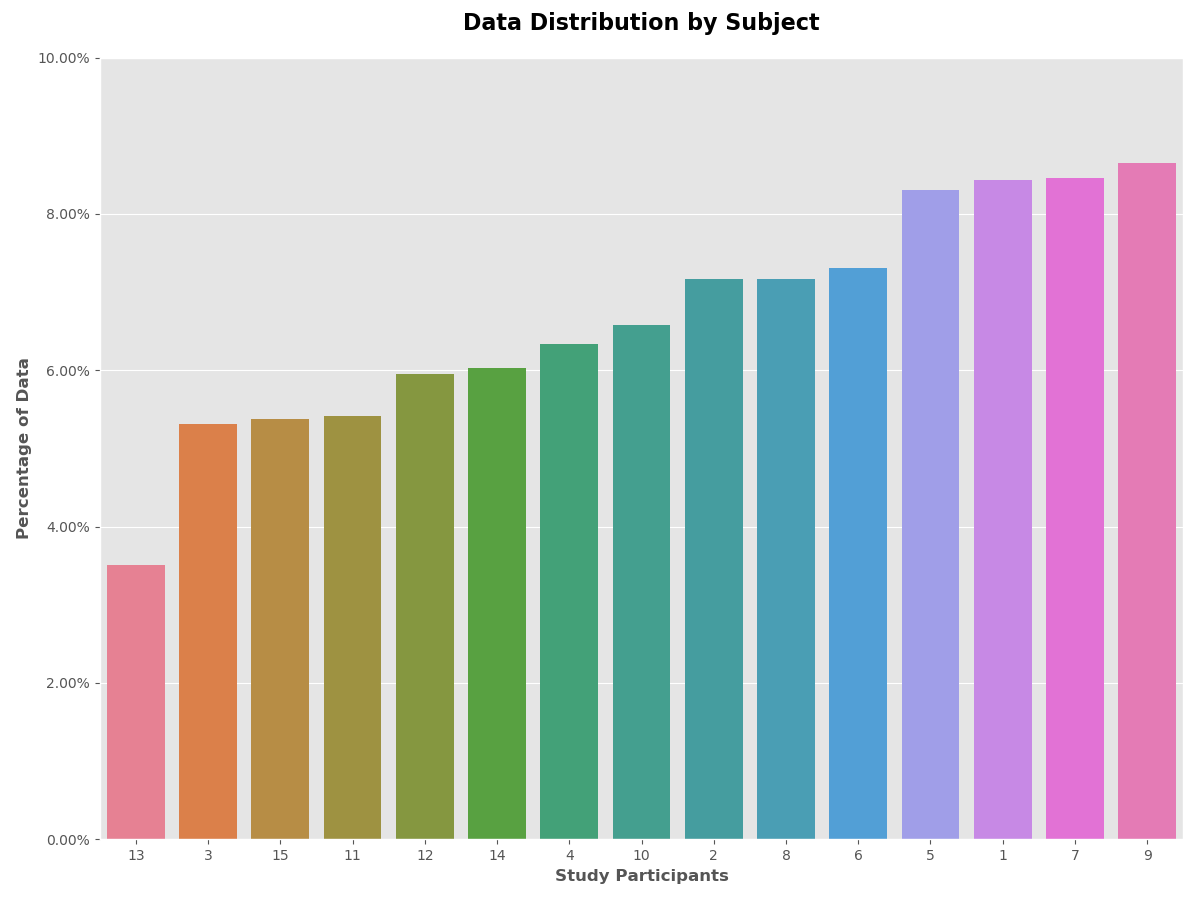

In [2]:
from IPython.display import Image
Image(filename='images/SubjectDistribution.png')

##### Distribution by Activity

Unfortunately, the distribution of data relative to activity type is heavily skewed, as one can see below.

The first three activites only account for about 2.5% of the data each. Compounding that, *Talking while Standing* and *Working at Computer* dominate the distribution, each coming in at over 30%. The heavily skewed nature of the target distribution will be problematic during the modeling process, and an explanation regarding why will be given later on, after looking a little closer at the data we have, and once we are closer to modeling.

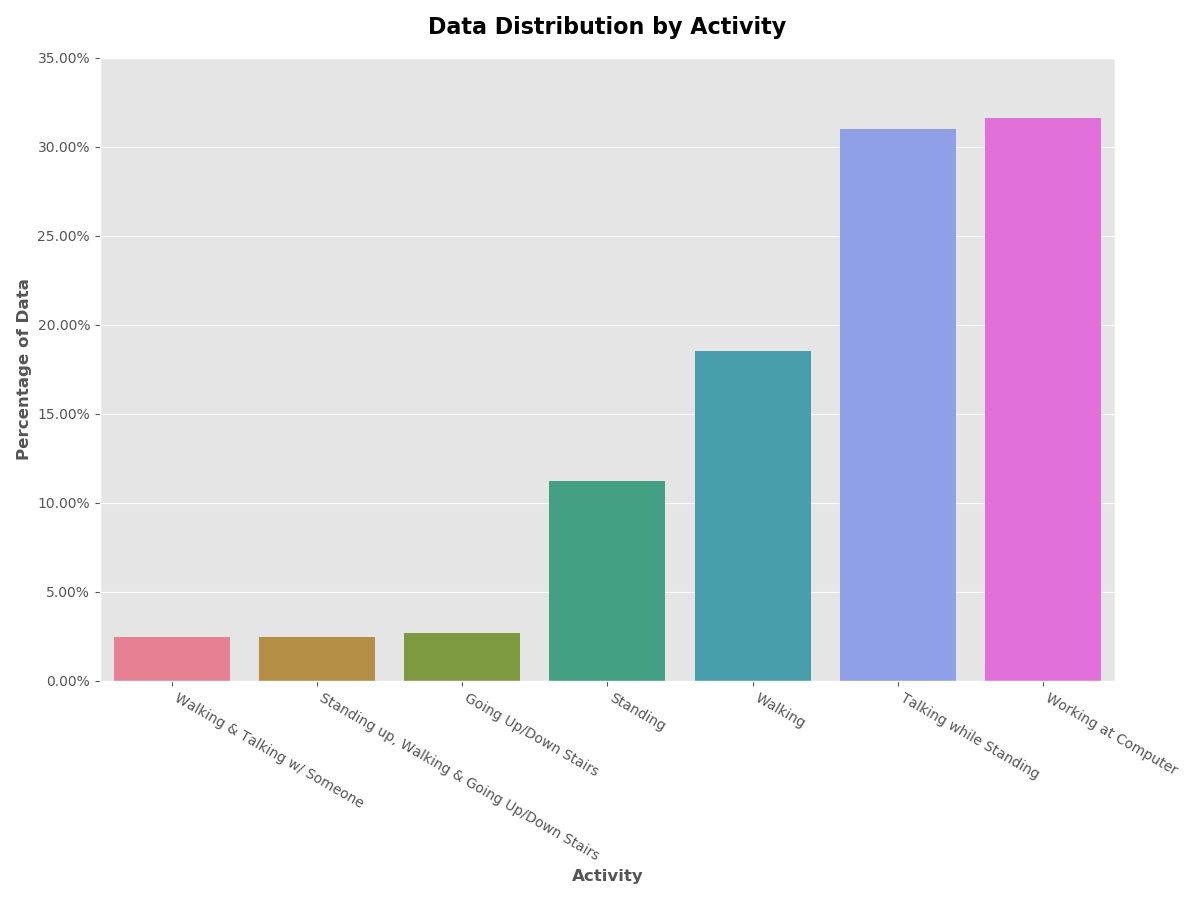

In [3]:
# distribution of activities
Image(filename='images/InititalActivityDistribution.png')

#### A look at the Data

Looking at the table of summary statistics below, a question that will pop up (if it hasn't already) is, "What do these numbers mean?"

In [4]:
df.pivot_table(index=['label'], values=['x_acc','y_acc','z_acc'], aggfunc=[np.mean, np.std])

mean               \
                                                   x_acc        y_acc   
label                                                                   
Going Up/Down Stairs                         2000.554449  2385.493844   
Standing                                     1996.272755  2378.303095   
Standing up, Walking & Going Up/Down Stairs  1969.489431  2371.051965   
Talking while Standing                       1998.340516  2389.217249   
Walking                                      1976.819111  2386.292905   
Walking & Talking w/ Someone                 2027.107076  2374.075277   
Working at Computer                          1977.689653  2376.558532   

                                                                 std  \
                                                   z_acc       x_acc   
label                                                                  
Going Up/Down Stairs                         1997.001573  111.237068   
Standing                                     1965.729391  121.542182   
Standing up, Walking & Going Up/Down Stairs  1940.448703  110.537379   
Talking while Standing                       1973.384663  105.939770   
Walking                                      1978.708646  124.060266   
Walking & Talking w/ Someone                 1952.189366  121.550283   
Working at Computer                          1966.415593  101.580145   

                                                                     
                                                  y_acc       z_acc  
label                                                                
Going Up/Down Stairs                         107.876324   91.282547  
Standing                                      89.361650   70.465477  
Standing up, Walking & Going Up/Down Stairs   87.912346  108.297306  
Talking while Standing                        95.753926   63.859416  
Walking                                      114.916367   90.972573  
Walking & Talking w/ Someone                  87.496785   76.124904  
Working at Computer                           99.827210  123.734287

According to [this website](https://learn.sparkfun.com/tutorials/accelerometer-basics/all), "[Accelerometers] measure in meters per second squared $\left( \frac{meters}{second} \right)^2$, or in G-forces (g, where 1 g = 9.8 $\left( \frac{meters}{second} \right)^2$)" (at least on this planet, but we don't need to get into that...)

In addition to these units not being overly intuitive for most people, the actual values aren't of great concern for modeling. By standardizing each of the three dimensions (mean = 0,  variance = 1), the units will become "standard deviations from the (overall) mean"

In [5]:
dtype_dict = {'seq':object,
              'x_acc':float,
              'y_acc':float,
              'z_acc':float,
              'label':object,
              'subject':object}

# check src/format_data.py for aggregate_subjects() function
scaled_df = standardize_df(df, ['x_acc','y_acc','z_acc'], ['seq','label','subject'], dtype_dict)

After the data has been standardized, the same table as above can be interpretted more intuitively.

For example, you'll notice that the mean for "Going Up/Down Stairs" in the Z dimension is the highest out of any of the activities. This means that, although the *overall* mean for the Z dimension is 0, a relatively high value (close to 0.3) would suggest that the activity being performed is more likely to be "Going Up/Down Stairs."

In [6]:
scaled_df.pivot_table(index=['label'], values=['x_acc','y_acc','z_acc'], aggfunc=[np.mean, np.std])

mean                      \
                                                x_acc     y_acc     z_acc   
label                                                                       
Going Up/Down Stairs                         0.115863  0.029617  0.279544   
Standing                                     0.077413 -0.042065 -0.051522   
Standing up, Walking & Going Up/Down Stairs -0.163103 -0.114349 -0.319159   
Talking while Standing                       0.095982  0.066734  0.029521   
Walking                                     -0.097282  0.037582  0.085884   
Walking & Talking w/ Someone                 0.354308 -0.084210 -0.194865   
Working at Computer                         -0.089464 -0.059456 -0.044258   

                                                  std                      
                                                x_acc     y_acc     z_acc  
label                                                                      
Going Up/Down Stairs                         0.998916  1.075375  0.966373  
Standing                                     1.091457  0.890810  0.745991  
Standing up, Walking & Going Up/Down Stairs  0.992633  0.876362  1.146502  
Talking while Standing                       0.951346  0.954532  0.676055  
Walking                                      1.114069  1.145554  0.963092  
Walking & Talking w/ Someone                 1.091529  0.872220  0.805905  
Working at Computer                          0.912196  0.995137  1.309927

#### Outlier Detection

In a non-sequential data set, outliers are (typically) defined by their distance from the main cluster of datapoints. In this data set, the definition of "outlier" is going to be defined as a **behavioral** outlier - a study participant that behaves differently from all the others for a given activity that could bias our model.

The plot below shows the standardized X-axis acceleration for each participant. Looking closely at *Participant 12*, one will notice that while most of the other participants have very little x axis acceleration while working at their computer, *Participant 12's* measurements seems to jump around quite frequently.

If there were more participants in this study who showed behaviour closer to that of the "normal" participants, one might consider removing participant 12 altogether. However, due to the small sample size (referring to the number of participants in the study) and the naturally high ambiguity of the problem (as mentioned above, people move very differently), moving forward with a 'mental grain of salt' with regard to participant 12 seems to be the most prudent option.

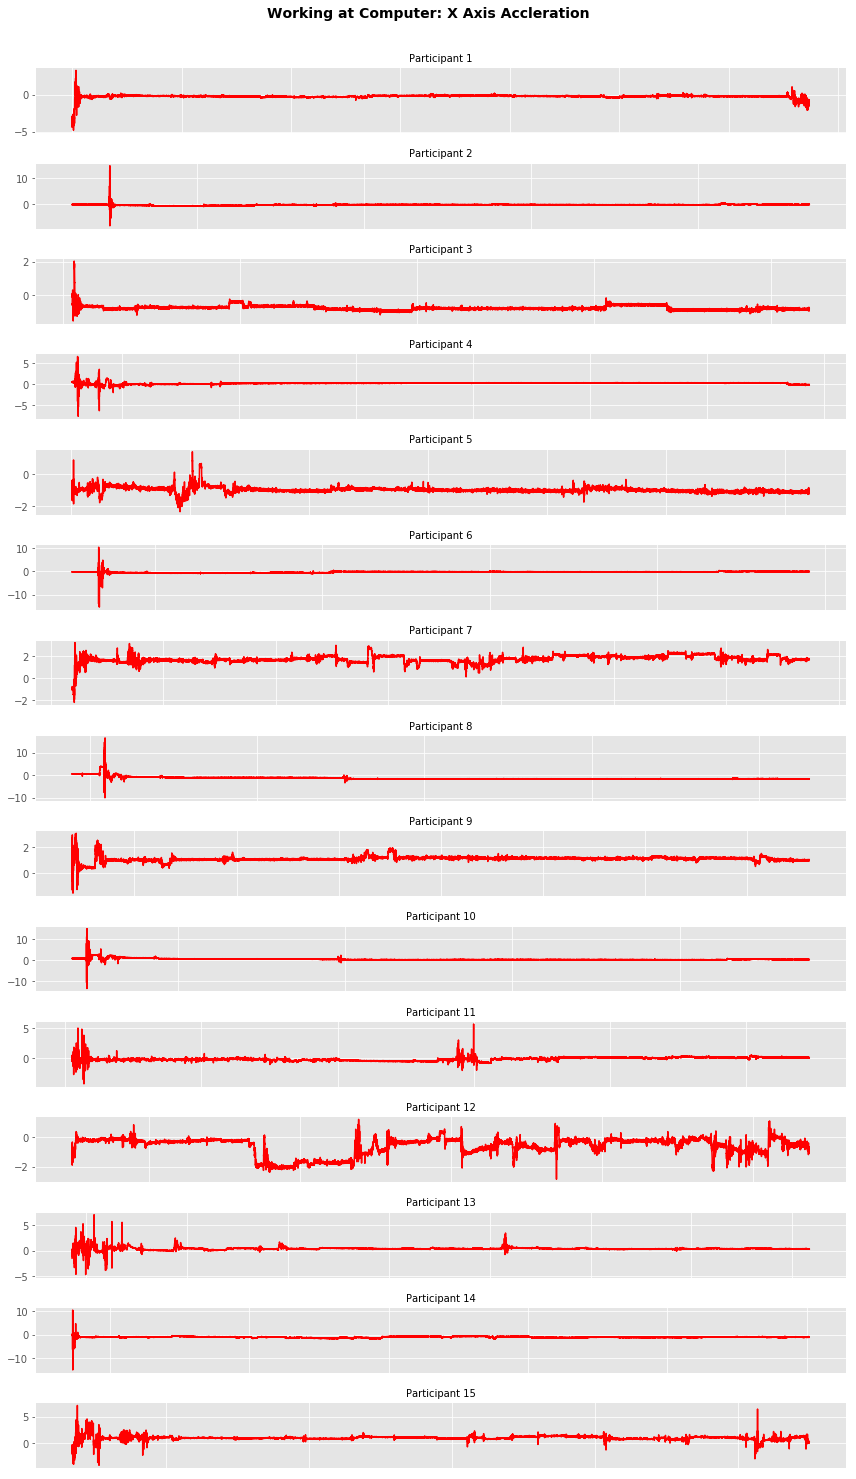

In [7]:
display_df = scaled_df[scaled_df['label'] == 'Working at Computer']

# check plotting.py for subject_comparison_plot()
from src.plotting import *
subject_comparison_plot(display_df, 'x_acc', 'red', 'Working at Computer: X Axis Accleration')

#### How do the Movement Patterns Differ?

Since the end goal is to identify a particular activity based on the various dimension measurements, looking at how these measurements differ across time will show what the various models will be able to use to differentiate between activities. For the sake of demonstration, the first subject will be used as an example.

In [8]:
display_df = scaled_df[scaled_df['subject'] == '1']

The plots below show the behaviour of the different activities in sequential order, for each dimension. Although there are some similarities between the different activites, there are some movements that can be thought of quite intuitively.

For example, one will notice that *Walking* has a consistently dense variation around its mean in each dimension. This makes intuitive sense in that, while walking, there is going to be some consistent upward and downward oscillation as the subjects rolls off the ball of their foot with each step. In addition, the slight swinging of the arms will rotate the shoulders slightly, which in turn will ever so slightly move the chest (where the accelerometer is located).

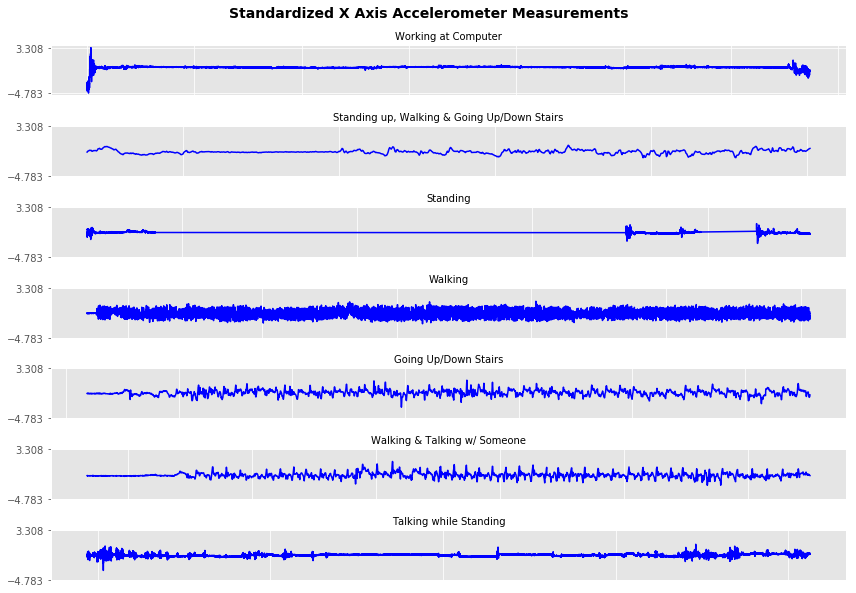

In [9]:
y_range = [np.min(display_df.x_acc), np.max(display_df.x_acc)]
dimension_plot(display_df, 'x_acc', y_range, 'blue', 'Standardized X Axis Accelerometer Measurements')

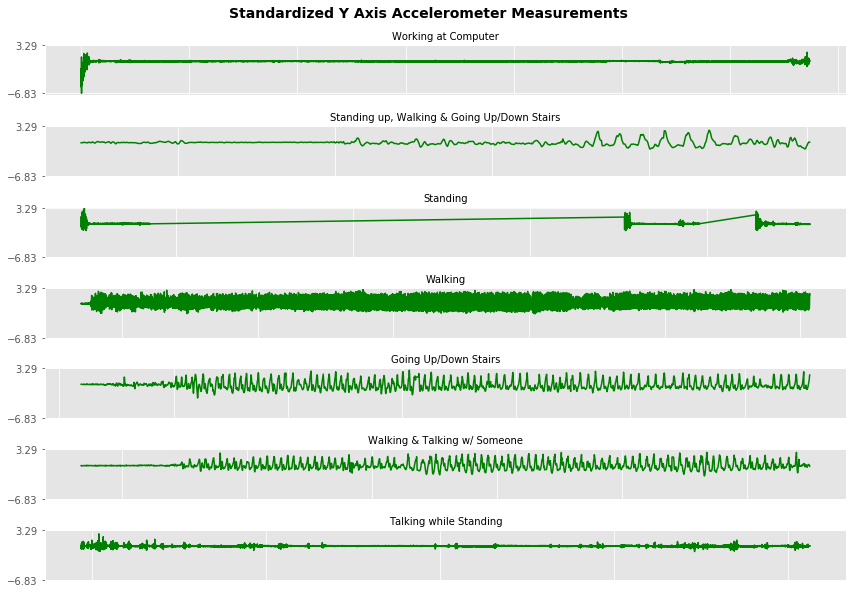

In [10]:
y_range = [np.min(display_df.y_acc), np.max(display_df.y_acc)]
dimension_plot(display_df, 'y_acc', y_range, 'green', 'Standardized Y Axis Accelerometer Measurements')

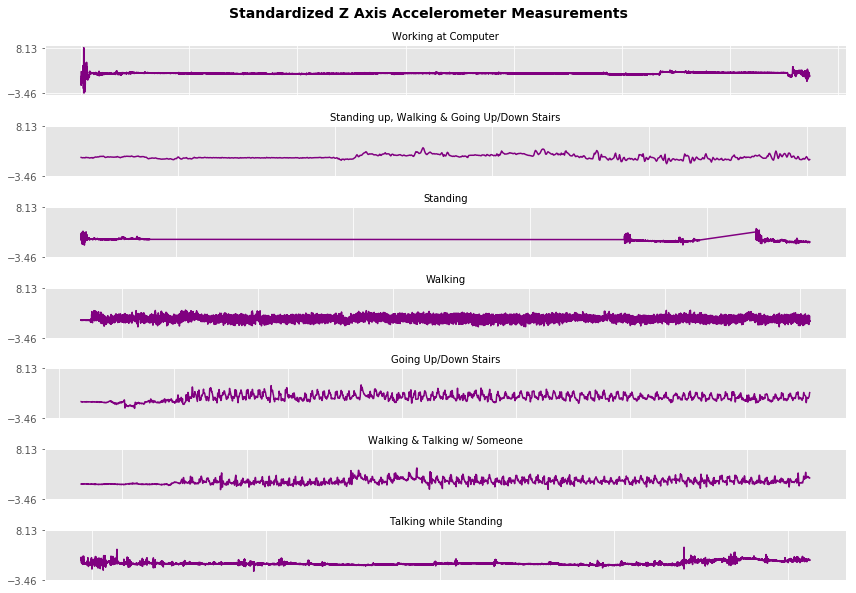

In [11]:
y_range = [np.min(display_df.z_acc), np.max(display_df.z_acc)]
dimension_plot(display_df, 'z_acc', y_range, 'purple', 'Standardized Z Axis Accelerometer Measurements')

### Modeling

As eluded to by the, "3 Different Approaches" part of the title, there is more than one way to approach the modeling process. The three approaches that will be looked at are as follows.

#### The "Traditional" Approach

* This is how the modeling process is typically approached in data science and is how the data has been treated thus far. Using this approach, all 15 study participants are concatenated into one large data set and a traditional train test split determines which observations are trained and tested on.
    
* This approach can be thought of (roughly) as answering the question, "Which model is best at learning a population's movement pattern?"
    
* One **glaring drawback** of this approach is the testing set consists of instances of a behavioral pattern that was used to train the model. In other words, the model isn't being tested on identifying unseen behavior patterns - it is only being tested on identifying *unseen instances of a known behavior pattern.*

#### The "Generalizable" Approach

* This approach attempts to address the above drawback. This approach will train on n - 1 subjects (14 in this case) and be tested on the $n^{th}$ subject, and can be thought of (roughly) as answering, "Which model is best at generalizaing to unseen subjects?"
    
* Although not necessarily a drawback, one thing to keep in mind with this approach is it's intrinsic difficulty; as shown in the *Outlier Detection* section, people move very differently. This approach does assume there is some consistent, underlying pattern across all subjects.


#### The "Individual" Approach

* Finally, the "Individual" approach will split each subject into a training and testing set, and see which model is best at learning that individual's behavior. This can be thought of (roughly) as answering the question, "Which model is best at learning and individuals movement pattern?"

Prior to any modeling, however, the evaluation metric by which the various models that are tested will be assessed should be defined, with clear reasoning.

##### Evaluation Metrics

There a few different metrics one could use for a classification problem, the most common being Precision, Recall or Accuracy. Precision seeks to minimize false positives and Recall seeks to minimize false negatives, while Accuracy takes a more balanced approach. Accuracy will be used as the evaluation metric, however *why* this will be used as the evaluation metric deserves a short explanation.

Although this data set has seven possible classifications, an explanation using a ficticious dichotomous decision process will drive the point home more directly.

A classic example of a process like this is medical testing. Imagine a test that tests the patient for cancer. If the patient tests positive (i.e. the test says they have cancer), they go on to the next step in the diagnosis process which is an additional $1,000 test. If the patient tests negative (the test says they don't have cancer), they are released and are able to continue with their lives.

It is clear that there are two ways the testing process can be wrong in this situation:

1. The test says they **do** have cancer when they in fact do not. This is called a False Positive. (FP for short)
2. The test says they **do not** have cancer when they in fact do. This is called a False Negative. (FN for short)

When deciding what evaluation metric to optimize for, one must take into account the costs of being wrong. In the above scenario, the cost of a FP is \\$1,000 and the time and inconvenience of an additional test to the patient who does not in fact have cancer. On the other hand, the cost of a FN is telling the patient they are okay when in reality they should start treatment immediately. The latter is clearly the worse of the two options; a patient that doesn't know they have cancer runs the risk of the cancer metastasizing, which would not only cause their medical bills to be much higher than \\$1,000 in the future, but would also increase their chance of death.

In this situation, one should be willing to sacrifice at least a couple FP's to save one FN, and would therefore choose Recall as the performance metric.

Coming back to the problem at hand, there are seven different possible classifications. This means there are six ways to be *wrong* for each class. With seven classes, that comes out to **42 different ways to be wrong, and only seven ways to be right**. Since there is no clear evaluation of the costs of being wrong (as there are in the example above), I will be treating each incorrect prediction the same, and therefore using accuracy as my evaluation metric. That is, misclassifying an observation as *Walking*, when it is actually *Standing*, will be treated the same as misclassifying an observation as *Walking & Talking w/ Someone*, when it is actually *Working at Computer*.

##### Feature Engineering: Bringing in the Sequential Nature of the Data

Since this problem has a sequential aspect to it, I am going to create a few new features that effectively allow the model to "look back" at previous acceleration measurements.

One of the main questions that needs to be addressed with regard to any sequential model is:

* Should the model have access to the previous state of the subject?

Another way of phrasing this is; do we want our model to be able to use the activity the subject was performing "a moment ago" to predict the activity the subject is currently performing?

While many sequential modeling frameworks take advantage of this, I am going to assume that the only sequential aspect of the data that we would like to preserve is the accelerometer's measurements in each dimension (and any features that can be derived from these). There are a couple reasons for this:

1. The training data was presented in a very specific manner; that is, the activities were ordered as they are written at the beginning of this report (i.e. in each file, all the observations for *Working at Computer* were at the beginning of the file and immediately followed by all the observations for *Standing up, Walking and Going Up/Down Stairs*, etc.) I am assuming this purely due to the design of the experiment. In the real world, people don't follow a monotonous routine of repeating the same pattern of movements over and over again, and we would ideally like to build a model that can predict a subjects activity even if they don't perform the activities in the same order as the training data.


2. If I were to give the model access to the previous state of the subject, the modeling process would become arbitrarily easy in the sense that a highly accurate model would be to just predict the previous activity state as the current activity state. This is tangential to the problem outlined in point one - the design of the experiment had each subject perform one activity after another. A natural thought then becomes, "Just shuffle the data and this problem evaporates". Unfortunately, shuffling the data would compromise the sequential nature of the accelerometer measurements, which we know we want to take advantage of.

In order to allow our model to be able to view the sequential nature of the data set without shuffling the data, I am going to introduce new variables that allow the model to look back in time, while still preserving the independence of the observations.

An illustration of what is happening is shown below.

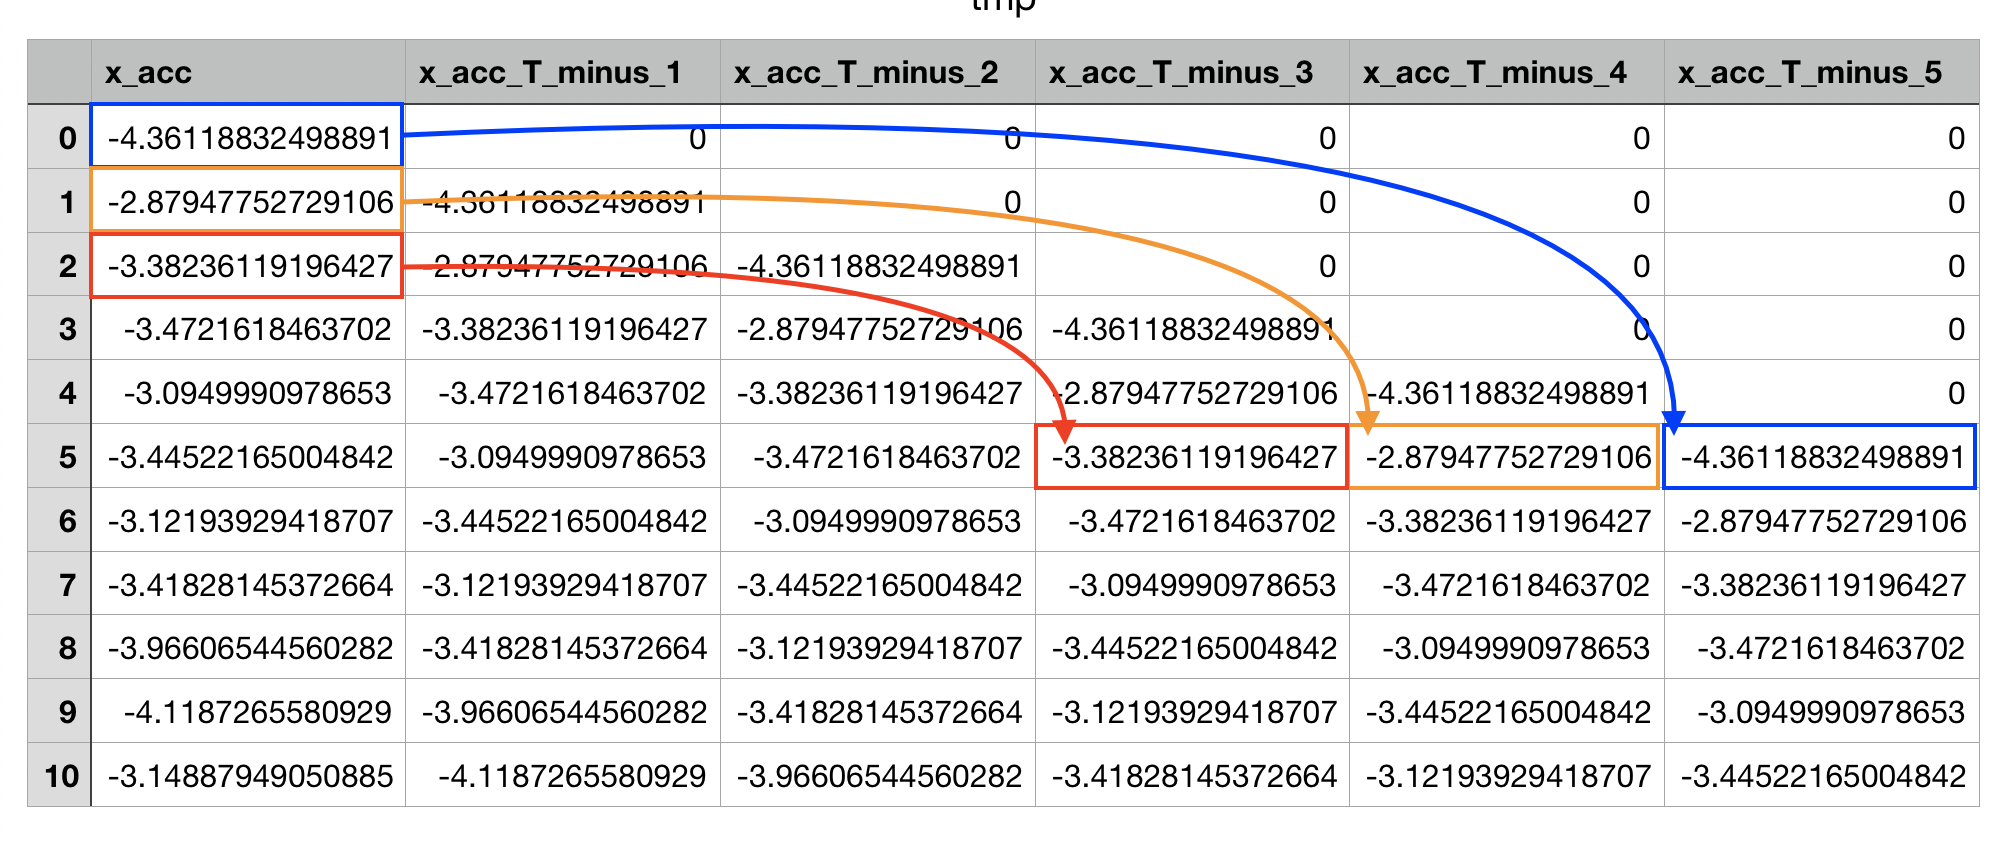

In [12]:
Image(filename='images/timelag_illustration.png')

As shown above, this process necessarily imputes some 0's into the datat set. Any observations with 0 were dropped prior to modeling. Two separate data sets were created, one with a 5 step time lag (shown above) and one with a 15 step time lag, to determine if looking further back helps the model learn.

In order to ensure there the order in which the activities were performed during the study didn't affect the model, the data set was stratified by subject and activity before the lag was introduced. Therefore, for the 5 step time lag data set, 15 (subjects) x 7 (activities) x 5 (time lag induced) = 525 observations dropped. For the 15 step time lag data set, 1575 observations were dropped.

In addition to the above time lag features, I created various rolling statistical attributes such as:

* Rolling Average
* Rolling Variance
* Rolling Min
* Rolling Max
* Rolling Kurtosis
* Rolling Skewness

This will give each model tetsted a view at the various characteristics of the distribution of the **X, Y & Z** measurement over the previous 5 or 15 time steps.

#### Undersampling Rationale

As mentioned in the **Data Distribution by Activity** section, the skewed distribution of the activity can pose some problems in the modeling process. The skewed nature of the activity distribution is seen on a more granular "per subject" level as well, shown below.

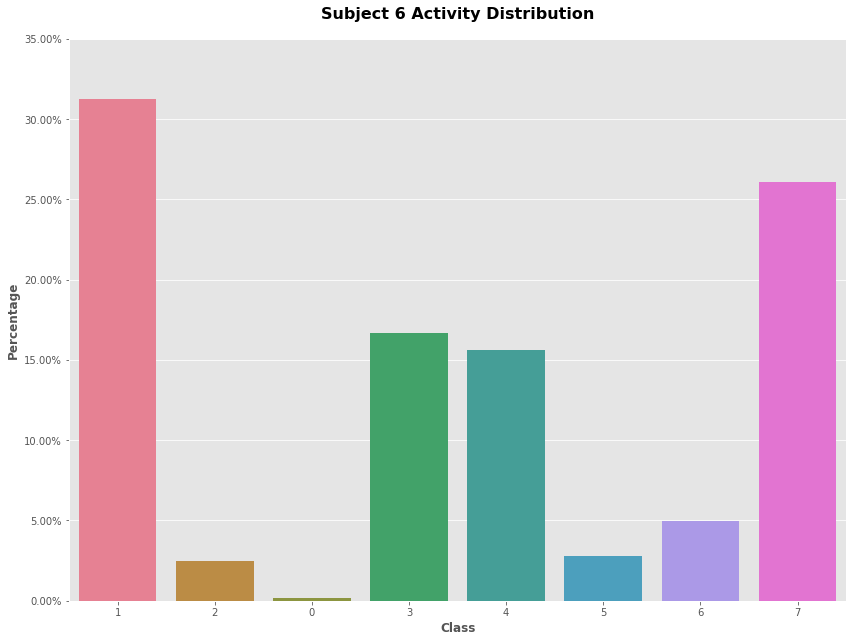

In [13]:
from collections import Counter

# creating dict with activity labels and percentage of data set
display_df = pd.read_csv('data/6.csv', names=['x','y','z','label'])
counter = Counter(display_df['label'])
counter = {k: v / sum(counter.values()) for k, v in counter.items()}

# converting dict to data frame for display purposes
display_df = pd.DataFrame.from_dict(counter, orient='index')
display_df.reset_index(inplace=True)
display_df.columns = ['Activity','Percentage']

barplot(display_df,
        values_col='Percentage',
        labels_col='Activity',
        x_label='Class',
        y_label='Percentage',
        title='Subject 6 Activity Distribution')

The reason an unbalanced data set can be problematic when optimizing a model with respect to accuracy is most clearly illustrated in a binary setting, illustrated in the plot below.

Since the equation for accuracy is the number of correctly classified over all possible classifications:

$$
Accuracy = \frac{TP + \mathbf{TN}}{TP + \mathbf{FP} + TN + FN}
$$

If the below plot was illustrating the distribution of a data set with 100 observations, achieving 100% accuracy would result in correctly classifying all of the positive and negative observations. 

$$
Accuracy = \frac{90 + \mathbf{10}}{90 + \mathbf{0} + 10 + 0} = 1 = 100\%
$$

However, by accepting the hit of 10 false positive's, a 90% accuracy can be easily reached with a "model" that doesn't look at any inputs, and purely manipulates the target distribution to it's advantage.

$$
Accuracy = \frac{90 + \mathbf{0}}{90 + \mathbf{10} + 0 + 0} = 0.9 = 90\%
$$


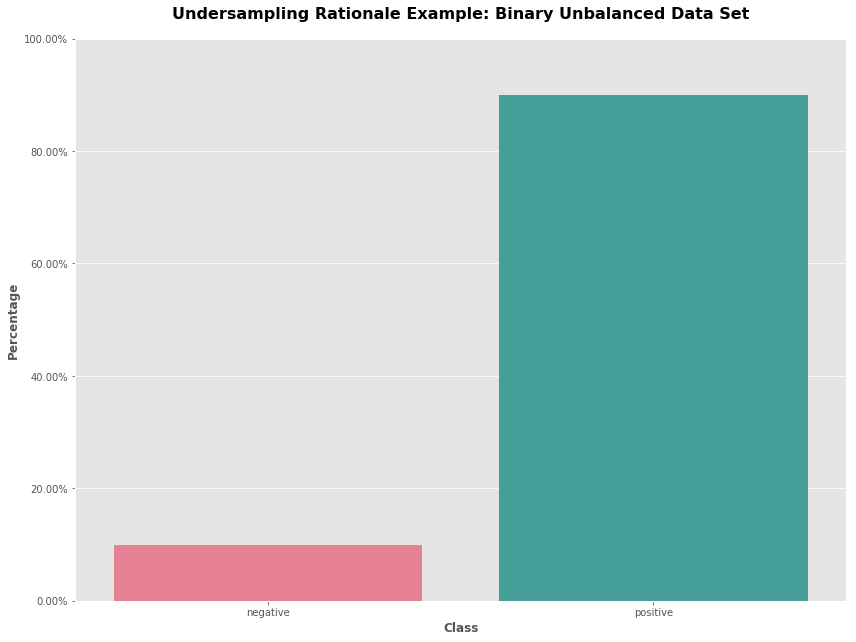

In [14]:
barplot(pd.DataFrame({'percentage': [0.1, 0.9], 'class': ['negative','positive']}),
        values_col='percentage',
        labels_col='class',
        x_label='Class',
        y_label='Percentage',
        title='Undersampling Rationale Example: Binary Unbalanced Data Set')

So, in order to stymie this in the problem at hand, [Random Undersampling](https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.under_sampling.RandomUnderSampler.html#imblearn.under_sampling.RandomUnderSampler) was employeed in order to adjust the target distribution. This process randomly drops instances of the majority classes in order to bring the target distribution to that which resembles a discrete uniform distribution. After this was performed, the data distribution with respect to the activity is shown below.

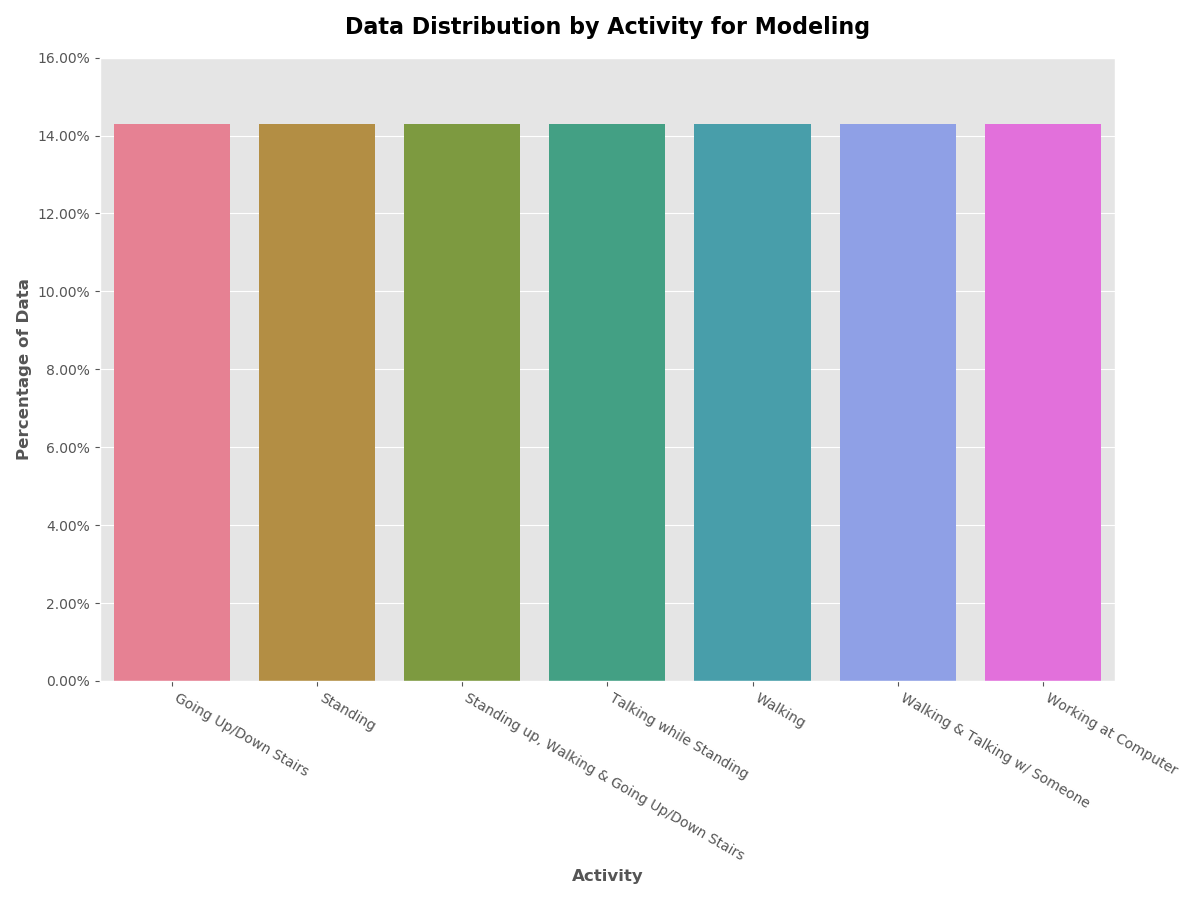

In [15]:
Image(filename='images/ModelingActivityDistribution.png')

##### Models Tested

After creating the lagged variables and undersampling as mentioned above, fitting a variety of models to the data set will show which model is the best for the given approach. The models that were tested were:

1. Random Forest (comprised of 500 decision trees).
2. Multi Layer Perceptron (two hidden layers of 100 neurons each).
3. AdaBoost Classifier (500 decision "stumps", only allowed to make one split).
4. Gradient Boosting Classifier (500 decision "stumps", only allowed to make one split).
4. Multinomial Logistic Regression (using "One-vs-Rest" methodology, which fits a binary problem for each class).

In order to take advantage of standardizing the training data, as shown above, each of these models were put into a `Pipeline()` object that started with a `StandardScaler()` object. Modeling in this manner allows the `Pipeline()` object to be used in cross validation, ensuring that the training data is standardized and used to fit the model, while the testing data is transformed using the training data values. An example of one of the pipelines is shown below.

```python
rf_pipeline = Pipeline([
   ('scaler', StandardScaler()),
   ('model', RandomForestClassifier(n_estimators=500,
                                    random_state=5,
                                    n_jobs=-1,
                                    verbose=1))
])
```

### Results

#### The "Traditional" Approach

After all the above was performed, the various models showed the below results. Eight fold cross validation was performed on the two data sets mentioned (5 step time lag & 15 step time lag).

In [16]:
from IPython.display import HTML, display
display(HTML("<table><tr><td><img src='approach_1/images/Approach1_InitialCV_Lag5.png'></td><td><img src='approach_1/images/Approach1_InitialCV_Lag15.png'></td></tr></table>"))

,


As shown above, the 15 Step Time Lag data set shows a huge increase in prediction accuracy, with the leading model, a Gradient Boosted Classifier using 500 decision stumps as the base estimators achieving an average of 99.5% accuracy over 8 testing sets on the 15 step time lag data set.

| Model | 5 Step Time Lag Accuracy | 15 Step Time Lag Accuracy |
| --- | --- | --- |
| Gradient Boosted Classifier | 64.6% | 99.5%
| Random Forest | 74.2% | 97.2%
| Multi Layer Perceptron | 66.0% | 95.1%
| Multinomial Logistic Regression | 33.6% | 59.9%
| **AdaBoost Classifier** | **44.5%** | **27.1%**

Perhaps what is most interesting about these results is the behavior of the AdaBoost Classifier; while all other models saw a significant increase in the average accuracy, the AdaBoost Classifier showed a decrease, and a significant one at that. In addition to this, it is intriguing that the two boosting methods showed substantially different results, despite the minor differences in the fitting algorithm (Gradient Boosting fits the next estimator on the *residuals* of the previous estimator while AdaBoost places more emphasis on instances that were misclassified by *up-weighting* the instances that were misclassified). The cause of this would require further exploration.

#### The "Generalizable" Approach

This approach proved to be the most difficult of all three. Although the average accuracy for each model was greater than that of chance (14.26%), the variance of the test accuracy over the 8 random subjects tested was drastically greater than the variance of the other two approaches.

As mentioned, I assume this is due to the intrinsic difficulty of this approach; the other two approaches had the benefit of being able to train on instances of a behavioral pattern that was **also** in the the testing set, whereas this approach didn't have that crutch.

Moving to the 15 step time lag data set did see a drastic increase in accuracy, on par with the other approaches. Once again, however, this corresponded to *another* increase in the variance of the testing accuracy.

In [17]:
display(HTML("<table><tr><td><img src='approach_3/images/Approach3_CV_Lag5.png'></td><td><img src='approach_3/images/Approach3_CV_Lag15.png'></td></tr></table>"))

,


#### The "Individual" Approach

Below are 30 total plots, 2 for each subject, showing the 8 Fold CV Accuracy for both the 5 Step Time Lag data set (left) and the 15 Step Time Lag data on the right.

In [18]:
for subject_id in range(1, 16):
    display(HTML(f"<table><tr><td><img src='approach_2/images/Approach2_InitivalCV_Lag5_Subject{subject_id}.png'></td><td><img src='approach_2/images/Approach2_InitivalCV_Lag15_Subject{subject_id}.png'></td></tr></table>"))

,


,


,


,


,


,


,


,


,


,


,


,


,


,


,


Contrasting the results from the "Traditional" approach, where the rank of the models jumped around, the model ranking below was consistent across all subjects and didn't change from the 5 Step Time Lag dat set to the 15 Step Time Lag data set.

| Model | Rank |
| --- | --- |
| Random Forest | 1
| Gradient Boosted Classifier | 2
| Multi Layer Perceptron | 3
| Multinomial Logistic Regression | 4
| AdaBoost Classifier | 5

Although the above ranking stays consistent across subjects and the variance of the top models is relatively low on a **intra**-subject basis, the **inter**-subject variance is somewhat high, ranging from a low of around 60% for subject 15 and a high of ~83% for subject 5 (with regard to the Random Forest).

### Conclusion

As this analysis has shown, the accuracy that one can expect from a classification project such as this depends greatly on the problem one is trying to solve.

The "Generalizable" approach seems to resemble the problem that wearables (i.e. fitbit, Apple Watch, etc.) are up against, despite being worn on the wrist of the user as opposed to the chest. Having an Apple Watch myself, I certainly have a newfound appreciation for how difficult the problem is. That said, I've noticed that quite a few minutes go buy before I get the, "It looks like you are doing X, would you like to track this activity," message. One wonders whether increasing the time lag incrementally would show a reduction in variance.

With regard to the "Traditional" approach, although the Gradient Boosted model outperformed the Random Forest by 2 percentage points, the fact that the Random Forest takes drastically less time to train and can be parallelized would lead me to choose it over the Gradient Boosted Classifier.

The "Individual" approach points to the Random Forest as the best model to learn an individual's movement pattern as well.

### Next Steps (if desired)

In the same way that software is never finished, data analysis is never truly exhausted. Below are some thoughts I have regarding ways to change the analysis, or push it forward.

#### Feature Engineering Improvements

* Performing various mathematical aggregations of the features would likely lead to a greater increase in accuracy, since people move in the three dimensions **simultaneously.** In addition, there are some signal processing transforms (such as the Fourier Transform, Impulse Reponse Function, etc) would likely be valuable features. At the time of this writing, I am mathematically unfamiliar with these concepts, and although I find myself in a time where one has the ability to apply a function created by someone else without it understanding the underlying concept, this seems intellectually immoral to me.

#### Modeling Improvements
* After deciding on what approach to pursue, `GridSearchCV` could be used to find the best hyperparameters to use for a given model architecture.
* Increase the lag, allowing the models to look further back in time.
    * Since the 15 step time lag data set showed a greater accuracy than the 5 step time lag data set, it would be interesting to see at what point this process reaches diminishing returns (i.e. create 25, 35, 45 etc. step time lag data sets, train the above models on them and see if there is a linear increase in accuracy or linear decrease in variance of accuracy).
        * Of course, one of the downsides of increasing the lag is, if this model were to go into production, data would have to be cached for the same amount of the lag before the model could make a prediction.
* Test models that are specifically designed for sequential data, such as an RNN or LSTM.